In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('use: ',device)

use:  cuda


In [3]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [4]:
training_epoch =  100
lr_list = []
for x in range(1,training_epoch+1):
    if x % 8 == 0:
        lr_list.append(x)
print(lr_list)

[8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96]


In [5]:
batch_size = 64

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True, drop_last=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size, shuffle=False, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
    nn.init.xavier_uniform(m.weight)
    if type(m.bias) != type(None):
      nn.init.constant_(m.bias.data, 0)
   
  elif classname.find('Conv') != -1:
    nn.init.xavier_uniform(m.weight)
    if type(m.bias) != type(None):
      nn.init.constant_(m.bias.data, 0)

  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [7]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [8]:
model = GoogLeNet().to(device)
model.apply(init_weights)

/home/devcat/anaconda3/envs/devcat/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if __name__ == '__main__':
/home/devcat/anaconda3/envs/devcat/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


GoogLeNet(
  (pre_layers): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (a3): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, m

In [9]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer,
                                   milestones=lr_list,
                                   gamma=0.96)

In [10]:
total_batch = len(trainloader)
print(f'total_batch : {total_batch}')

total_batch : 781


In [11]:
train_acc_list = []
test_acc_list = []
pbar = trange(training_epoch, desc='Loss : 0', leave=True, position=0)

for epoch in pbar:
    train_acc = 0
    test_acc = 0
    model.train()
    for X,y in trainloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1)==y).float().mean()
    train_acc_list.append(train_acc/total_batch) #acc per epoch
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        if epoch%8 == 0:
            print('epoch: {:3d}, lr={:.6f}'.format(epoch, lr))
    scheduler.step(loss)
    model.eval()
    pbar.set_description("Loss : %.3f" % loss)
    for X,y in testloader:
        with torch.no_grad():
            X = X.to(device)
            y = y.to(device)
            result = model(X)
            test_acc += (result.argmax(1)==y).float().mean()
    test_acc_list.append(test_acc/len(testloader))

Loss : 1.410:   0%|          | 0/100 [02:35<?, ?it/s]

epoch:   0, lr=0.100000


Loss : 0.527:   8%|▊         | 8/100 [24:24<4:11:05, 163.76s/it]

epoch:   8, lr=0.061271


Loss : 0.272:  16%|█▌        | 16/100 [46:12<3:48:57, 163.54s/it]

epoch:  16, lr=0.061271


Loss : 0.364:  24%|██▍       | 24/100 [1:08:01<3:27:11, 163.58s/it]

epoch:  24, lr=0.061271


Loss : 0.406:  32%|███▏      | 32/100 [1:29:49<3:05:21, 163.55s/it]

epoch:  32, lr=0.061271


Loss : 0.425:  40%|████      | 40/100 [1:51:38<2:43:31, 163.53s/it]

epoch:  40, lr=0.061271


Loss : 0.488:  48%|████▊     | 48/100 [2:13:26<2:21:43, 163.53s/it]

epoch:  48, lr=0.061271


Loss : 0.820:  56%|█████▌    | 56/100 [2:35:13<1:59:53, 163.48s/it]

epoch:  56, lr=0.061271


Loss : 0.359:  64%|██████▍   | 64/100 [2:57:01<1:38:06, 163.50s/it]

epoch:  64, lr=0.061271


Loss : 0.421:  72%|███████▏  | 72/100 [3:18:49<1:16:17, 163.48s/it]

epoch:  72, lr=0.061271


Loss : 0.457:  80%|████████  | 80/100 [3:40:37<54:28, 163.44s/it]  

epoch:  80, lr=0.061271


Loss : 0.230:  88%|████████▊ | 88/100 [4:02:24<32:41, 163.44s/it]

epoch:  88, lr=0.061271


Loss : 0.364:  96%|█████████▌| 96/100 [4:24:11<10:53, 163.40s/it]

epoch:  96, lr=0.061271


Loss : 0.343: 100%|██████████| 100/100 [4:32:30<00:00, 163.50s/it]


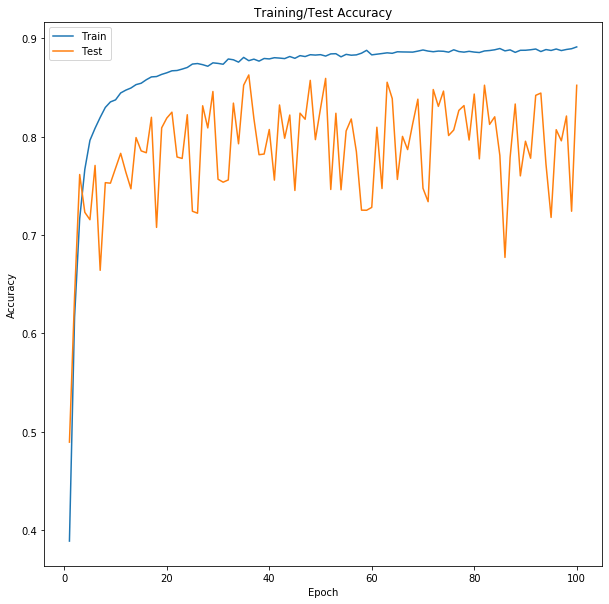

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Training/Test Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.plot(range(1, len(train_acc_list)+1), train_acc_list)
ax.plot(range(1, len(test_acc_list)+1), test_acc_list)
ax.legend(['Train', 'Test'])
plt.show()

In [14]:
torch.save({
            'epoch': training_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'train_accuracy': train_acc_list,
            'test_accuracy' : test_acc_list
            }, './save/GoogLeNet.checkpoint.pt')

In [15]:
cp = torch.load('./save/GoogLeNet.checkpoint.pt')

In [16]:
cp['test_accuracy'][99]

tensor(0.8524, device='cuda:0')